### Import all the essential libraries required to build, train, evaluate, and analyze a deep learning model, commonly used in EEG-based seizure detection tasks:


-> NumPy is used for numerical computations and handling multi-dimensional arrays,
which form the core structure of EEG signal data.

->TensorFlow and Keras provide the deep learning framework, where layers and the Model class are used to design neural network architectures such as CNNs and BiLSTMs.

->Training optimization is handled using callbacks like EarlyStopping, which stops training when validation performance no longer improves, ModelCheckpoint, which saves the best-performing model during training, and ReduceLROnPlateau, which lowers the learning rate when learning stagnates to improve convergence and prevent overfitting.

->Scikit-learn is used for model validation and performance evaluation, with Leave-One-Out cross-validation ensuring robust testing by training on all samples except one iteratively, and evaluation metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix measuring classification effectiveness.

->Matplotlib and Seaborn are visualization libraries used to plot EEG signals, training curves, and confusion matrices for interpretability and analysis.

->SciPy’s signal module provides signal processing tools such as filtering and spectral analysis, which are crucial for EEG preprocessing.

->OS module supports file and directory management for dataset handling, while the warnings module suppresses non-critical runtime warnings to keep outputs clean and focused.




In [1]:
import os

# Use GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Kill XLA completely
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = ""

# Disable MLIR / kernel_gen (CRITICAL)
os.environ["TF_DISABLE_MLIR_BRIDGE"] = "1"
os.environ["TF_DISABLE_MLIR_GRAPH_OPTIMIZATIONS"] = "1"

# Disable oneDNN (CPU vectorization noise)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Silence logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import metrics

# IMPORTANT: import layers explicitly
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    BatchNormalization,
    MaxPooling1D,
    Dropout,
    Bidirectional,
    LSTM,
    Dense,
    Concatenate
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal as scipy_signal
import warnings
warnings.filterwarnings("ignore")



In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#GPU configuration:


###This function configures TensorFlow to efficiently use a GPU for deep learning training and prints detailed diagnostic information in a Jupyter Notebook text (Markdown) cell.


->It first checks whether any physical GPUs are available using TensorFlow’s device listing utilities; if GPUs are detected, it enables **memory growth**, which allows TensorFlow to allocate GPU memory dynamically instead of reserving all memory at startup, preventing out-of-memory errors and improving resource sharing.

->The function then reports the number and names of detected GPUs. To accelerate training on modern NVIDIA RTX GPUs, it enables **mixed precision training**, which uses both 16-bit (FP16) and 32-bit (FP32) floating-point computations; this leverages **Tensor Cores** to significantly speed up matrix operations while maintaining numerical stability.

->**Soft device placement** is enabled so TensorFlow can automatically place operations on the GPU when possible and fall back to the CPU if needed.

->The function also retrieves and prints low-level **GPU hardware details** such as compute capability, which helps verify compatibility and performance characteristics.

->If GPU configuration is attempted after TensorFlow has already initialized devices, a runtime error is safely caught and reported. When no GPU is available, the function clearly indicates that computation will run on the CPU.

->Finally, the function is called immediately so that GPU configuration is applied as soon as the notebook or script is executed.


In [4]:
def configure_gpu():
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)

    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')

    if gpus:
        try:
            # Enable memory growth for all GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            print(f"Found {len(gpus)} GPU(s):")
            for i, gpu in enumerate(gpus):
                print(f"  GPU {i}: {gpu.name}")

            # Enable mixed precision training for RTX GPUs (faster training)
            # RTX GPUs have Tensor Cores that accelerate FP16 operations
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"Mixed precision enabled: {policy.name}")
            print(" (Utilizes Tensor Cores on RTX GPU for faster training)")

            # Set TensorFlow to use GPU
            tf.config.set_soft_device_placement(True)
            print("GPU acceleration enabled")

            # Display GPU compute capability
            gpu_details = tf.config.experimental.get_device_details(gpus[0])
            print(f"GPU Details: {gpu_details}")

        except RuntimeError as e:
            print(f"GPU configuration error: {e}")
    else:
        print("No GPU found. Running on CPU.")

    print("="*80 + "\n")

# Call GPU configuration at import time
configure_gpu()


GPU CONFIGURATION
Found 1 GPU(s):
  GPU 0: /physical_device:GPU:0
Mixed precision enabled: mixed_float16
 (Utilizes Tensor Cores on RTX GPU for faster training)
GPU acceleration enabled
GPU Details: {'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU'}



# STEP 1: DATA LOADING AND PREPARATION


###This function loads preprocessed EEG signal data and associated patient information in a format suitable for deep learning models and explains the rationale behind using .npz files.

 ->It scans a specified directory and loads all .npz files, where each file typically represents one patient and stores multiple related arrays in a single compressed container.

 ->For each file, the function extracts the patient ID from the filename, then loads the EEG signals—structured as multi-dimensional arrays with dimensions representing samples, channels, and time steps—and the corresponding binary labels indicating seizure or non-seizure events.

 ->These arrays are then appended to lists so that data from multiple patients can be processed together during training or cross-validation.

 ->The function also loads demographic embeddings from a separate .npy file, which encode patient-level information (such as age or gender) in a numerical format that can be fused with EEG features in neural networks.

 ->.npz files are used in deep learning because they efficiently store multiple NumPy arrays in a single compressed file, preserve exact numerical precision without loss, load significantly faster than text-based formats like CSV, and maintain consistent array shapes required by neural networks.

 ->This makes them ideal for large, high-dimensional data such as EEG signals, where fast I/O, memory efficiency, and structural integrity are critical for stable and reproducible model training.

In [5]:
def load_preprocessed_data(data_dir):
    """
    Loads window-level EEG data.

    Returns:
        eeg_data    : np.ndarray, shape (N, C, T)
        labels      : np.ndarray, shape (N,)
        patient_ids : list[str], length N
    """

    print("Loading preprocessed EEG data...")

    eeg_data = []
    labels = []
    patient_ids = []

    for file in sorted(os.listdir(data_dir)):
        if not file.endswith(".npz"):
            continue

        print(f"Loading {file} ...")

        patient_id = file.split(".")[0]
        data = np.load(os.path.join(data_dir, file))

        X = data["X"]          # (n_windows, C, T)
        y = data["y"]          # (n_windows,)

        eeg_data.append(X)
        labels.append(y)

        # ONE patient_id PER WINDOW
        patient_ids.extend([patient_id] * len(y))

    # FLATTEN TO WINDOW-LEVEL
    eeg_data = np.concatenate(eeg_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    print(f"Total EEG windows: {len(eeg_data)}")
    print(f"Total labels:      {len(labels)}")
    print(f"Total patient IDs: {len(patient_ids)}")

    return eeg_data, labels, patient_ids


In [6]:
def build_patient_metadata_map(csv_path):
    """
    Returns:
        meta_map: dict[str, dict]
            patient_id -> raw metadata fields
    """
    df = pd.read_csv(csv_path)

    meta_map = {}

    for _, row in df.iterrows():
        pid = row["patient_id"]

        meta_map[pid] = {
            "age_years": row[" age_years"],
            "gender": row[" gender"],
            "seizure": row[" seizure"],
            "localization": row[" localization"],
            "lateralization": row[" lateralization"],
            "eeg_channel": row[" eeg_channel"],
            "number_seizures": row[" number_seizures"],
            "rec_time_minutes": row[" rec_time_minutes"],
        }
        
    # assert demo_train.ndim == 2, demo_train.shape
    # assert demo_train.shape[0] == X_train.shape[0]

    return meta_map


# STEP 2: TIME-FREQUENCY REPRESENTATION (STFT)

###Convert raw EEG time-domain signals into a **time–frequency representation** using the **Short-Time Fourier Transform (STFT)**, which is especially useful for seizure detection because seizures exhibit distinctive frequency patterns that change over time.

->The `compute_stft` function takes a single EEG segment (organized by channels) and applies STFT independently to each channel using a specified sampling frequency (`fs`), window length (`nperseg`), and overlap (`noverlap`);

 ->STFT works by splitting the signal into short, overlapping time windows and applying the Fourier Transform to each window, allowing the model to observe how signal frequencies evolve over time rather than assuming stationarity.

 ->The complex STFT output is converted to magnitude values using the absolute function, since magnitude spectra capture signal energy distribution and are more meaningful for neural networks.

 ->The result is a 3D tensor representing channels, frequency bins, and time frames, which closely resembles image-like data suitable for CNNs.

 ->The `prepare_data_with_stft` function applies this transformation to the entire dataset patient-wise and segment-wise, enabling optional preprocessing control through the `use_stft` flag.

  ->Using STFT enhances deep learning performance in EEG analysis because seizures are characterized by transient oscillations and spectral shifts that are difficult to detect in raw time-domain signals but become clearly separable in the time–frequency domain.


In [7]:
def compute_stft(eeg_segment, fs=256, nperseg=128, noverlap=64):
    n_channels = eeg_segment.shape[0]
    stft_results = []

    for ch in range(n_channels):
        f, t, Zxx = scipy_signal.stft(eeg_segment[ch], fs=fs,
                                       nperseg=nperseg, noverlap=noverlap)
        stft_results.append(np.abs(Zxx))

    return np.array(stft_results)  # Shape: (n_channels, freq_bins, time_frames)


def prepare_data_with_stft(eeg_data, use_stft=True):
    if not use_stft:
        return eeg_data

    print("Computing STFT for time-frequency representation...")
    processed_data = []

    for patient_data in eeg_data:
        patient_stft = []
        for segment in patient_data:
            stft_segment = compute_stft(segment)
            patient_stft.append(stft_segment)
        processed_data.append(np.array(patient_stft))

    return processed_data


# STEP 3: DATA AUGMENTATION

###This function performs **data augmentation** on EEG segments to artificially increase dataset diversity and improve the generalization ability of deep learning models.

->It first creates a copy of the original EEG segment to preserve the raw data, then applies one of several biologically plausible transformations based on the selected augmentation type.

->In the **noise augmentation**, small Gaussian noise is added to simulate real-world recording disturbances such as sensor noise or environmental interference, helping the model become robust to slight signal variations.

->The **time-shift augmentation** randomly shifts the EEG signal along the time axis, which teaches the model that seizure patterns are invariant to small temporal misalignments and reduces sensitivity to exact onset positions.

->The **channel dropout augmentation** randomly zeros out a subset of EEG channels, mimicking electrode failures or poor contact and encouraging the model to learn spatially distributed patterns rather than relying on a few dominant channels.

->Overall, these augmentation strategies help prevent overfitting, improve robustness to noise and missing data, and make the model more reliable when applied to unseen EEG recordings in real clinical settings.


In [8]:
def augment_eeg_data(eeg_segment, augmentation_type='noise'):
    augmented = eeg_segment.copy()

    if augmentation_type == 'noise':
        # Add Gaussian noise (SNR ~20dB)
        noise = np.random.normal(0, 0.1, augmented.shape)
        augmented = augmented + noise

    elif augmentation_type == 'shift':
        # Time shifting
        shift = np.random.randint(-10, 10)
        augmented = np.roll(augmented, shift, axis=-1)

    elif augmentation_type == 'dropout':
        # Random channel dropout (10% of channels)
        n_channels = augmented.shape[0]
        dropout_channels = np.random.choice(n_channels,
                                           size=int(0.1 * n_channels),
                                           replace=False)
        augmented[dropout_channels] = 0

    return augmented

# STEP 4: ATTENTION MECHANISM

###This custom **AttentionLayer** implements a learnable attention mechanism that allows a neural network to focus on the most informative time steps in sequential EEG data, which is crucial for seizure detection where only certain temporal regions contain discriminative seizure activity.

->The layer extends Keras’s base `Layer` class and defines trainable parameters in the `build` method, including a **weight matrix** initialized using Glorot (Xavier) initialization for stable gradient flow and a **bias vector** initialized to zeros.

->During the forward pass in the `call` method, the input tensor—structured as batches of time sequences with extracted features—is linearly transformed and passed through a **tanh activation** to produce attention scores that capture the relevance of each time step.

->These scores are normalized using a **softmax function** across the temporal dimension, converting them into attention weights that sum to one and represent the relative importance of each time step.

->The original inputs are then scaled by these weights through element-wise multiplication, emphasizing seizure-relevant temporal patterns while suppressing less informative background activity.

->The `get_config` method ensures that the layer can be properly serialized and reloaded, making it compatible with model saving and deployment workflows in deep learning applications.


In [9]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch, time_steps, features)
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, time_steps, features)

        # Attention scores
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)

        # Normalized weights over time
        alpha = tf.nn.softmax(e, axis=1)

        # Weighted sum over time (THIS is the key fix)
        context = tf.reduce_sum(inputs * alpha, axis=1)

        return context


# STEP 5: CNN-BiLSTM MODEL WITH ATTENTION AND DEMOGRAPHICS

###This function builds a **hybrid CNN–BiLSTM deep learning model with attention and demographic fusion** for EEG-based seizure detection, combining spatial, temporal, and patient-specific information in a single architecture.

->The model uses two inputs: one for EEG signals and one for demographic embeddings, allowing it to learn both signal-level and subject-level patterns. If STFT features are used, the EEG input is reshaped to make the time–frequency representation compatible with one-dimensional convolutions.

->The **CNN blocks** consist of stacked Conv1D layers with increasing filter sizes that learn local spatial patterns across EEG channels and time, such as rhythmic discharges or spike-like activity, while **batch normalization** stabilizes training, **max pooling** reduces temporal resolution and noise, and **dropout** prevents overfitting.

->The extracted features are then passed to **Bidirectional LSTM layers**, which model long-range temporal dependencies in both forward and backward directions, enabling the network to capture seizure onset, evolution, and offset patterns more effectively.

->An **attention mechanism** is applied next to dynamically emphasize the most seizure-relevant time segments, improving interpretability and detection accuracy. Global average pooling compresses the attended temporal features into a fixed-length representation.

->In parallel, demographic data is processed through a dense layer to learn compact patient embeddings, which are concatenated with EEG-derived features to incorporate patient-specific variability.

 ->The **classification head** consists of fully connected layers with dropout for robust feature learning, and the final softmax output layer performs binary classification between seizure and non-seizure classes.

 ->The model is compiled using the **Adam optimizer** for efficient gradient-based learning, **sparse categorical cross-entropy loss** suitable for integer class labels, and evaluation metrics including accuracy, precision, and recall to assess clinical relevance.


In [10]:
def build_cnn_bilstm_model(input_shape, demographic_dim=14, use_stft=False):

    from tensorflow.keras import layers, Model
    from tensorflow import keras

    # --------------------
    # Inputs
    # --------------------
    eeg_input = layers.Input(shape=input_shape, name='eeg_input')
    demographic_input = layers.Input(shape=(demographic_dim,), name='demographic_input')

    # --------------------
    # EEG feature extractor
    # --------------------
    if use_stft:
        x = layers.Reshape((input_shape[0], -1))(eeg_input)
    else:
        x = eeg_input

    x = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.LayerNormalization()(x)
#     x = layers.BatchNormalization(
#     momentum=0.9,
#     epsilon=1e-5,
#     fused=False   # ← THIS is the key
# )(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.LayerNormalization()(x)
#     x = layers.BatchNormalization(
#     momentum=0.9,
#     epsilon=1e-5,
#     fused=False   # ← THIS is the key
# )(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.LayerNormalization()(x)
#     x = layers.BatchNormalization(
#     momentum=0.9,
#     epsilon=1e-5,
#     fused=False   # ← THIS is the key
# )(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # --------------------
    # Temporal modeling
    # --------------------
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.4)(x)

    x = AttentionLayer()(x)
    # x = layers.GlobalAveragePooling1D()(x)

    # --------------------
    # Demographic branch
    # --------------------
    d = layers.Dense(32, activation='relu')(demographic_input)

    # --------------------
    # Fusion + classifier
    # --------------------
    combined = layers.Concatenate()([x, d])

    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)

    combined = layers.Dense(64, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)

    output = layers.Dense(2, activation='softmax')(combined)

    model = Model(
        inputs=[eeg_input, demographic_input],
        outputs=output
    )

    # --------------------
    # ✅ CORRECT COMPILE
    # --------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
        run_eagerly=True   # REQUIRED on your system
    )
    
    return model


# STEP 6: LEAVE-ONE-PATIENT-OUT (LOPO) CROSS-VALIDATION

###This function implements **Leave-One-Patient-Out (LOPO) cross-validation**, a rigorous evaluation strategy widely used in EEG-based seizure detection to ensure true patient-independent generalization.

->In this approach, data from one patient is held out as the test set while the model is trained on data from all remaining patients, and this process is repeated so that each patient serves as the test subject exactly once.

 ->For every fold, the function concatenates EEG segments and labels from the training patients, aligns demographic embeddings with each EEG segment by repetition, and keeps the held-out patient’s data strictly unseen during training.

-> A CNN–BiLSTM–Attention model is then built and trained using GPU acceleration, with multiple **model checkpoints** to save the best-performing models based on validation accuracy and validation loss, as well as periodic snapshots to safeguard against training interruptions.

 ->**Early stopping** halts training when validation loss stops improving, preventing overfitting, while **learning rate reduction on plateau** improves convergence by lowering the learning rate when optimization stagnates.

 ->**TensorBoard logging** enables real-time monitoring of GPU usage, losses, and metrics.

 ->After training, the best model (based on validation accuracy) is reloaded and evaluated on the held-out patient using clinically meaningful metrics such as accuracy, precision, recall, F1-score, AUC–ROC, and the confusion matrix.

 ->These metrics are stored fold-wise to provide a comprehensive performance summary across all patients.

 ->Overall, this LOPO framework closely mimics real-world clinical deployment, where models must generalize to entirely unseen patients rather than benefiting from subject-specific data leakage.


In [11]:
def encode_metadata(meta):
    """
    Converts raw patient metadata dict into a numeric vector.

    Expected keys in meta:
        age_years
        gender
        seizure
        localization
        lateralization
        number_seizures
        rec_time_minutes
    """

    # ---------- Numeric ----------
    age = meta["age_years"]
    num_seizures = meta["number_seizures"]
    rec_time = meta["rec_time_minutes"]

    # ---------- Binary ----------
    gender = 1.0 if meta["gender"] == "M" else 0.0

    # ---------- Categorical (one-hot) ----------
    seizure_types = ["IAS", "GS", "FS", "AS"]   # adjust if needed
    seizure_oh = [1.0 if meta["seizure"] == s else 0.0 for s in seizure_types]

    localizations = ["T", "F", "P", "O"]
    localization_oh = [1.0 if meta["localization"] == l else 0.0 for l in localizations]

    lateralization = ["L", "R", "B"]
    lateralization_oh = [1.0 if meta["lateralization"] == lat else 0.0
                          for lat in lateralization]

    return np.array(
        [
            age,
            gender,
            num_seizures,
            rec_time,
            *seizure_oh,
            *localization_oh,
            *lateralization_oh
        ],
        dtype=np.float32
    )


In [12]:
def normalize_patient_id(pid):
    """
    Converts session-level IDs (e.g., PN00-3) to patient-level IDs (PN00)
    """
    return pid.split("-")[0]


In [13]:
def lopo_cross_validation(
    eeg_data,
    labels,
    patient_ids,
    metadata_map,
    input_shape,
    epochs=50,
    batch_size=32
):
    import numpy as np
    import os
    import tensorflow as tf
    from tensorflow import keras
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        f1_score, roc_auc_score, confusion_matrix
    )

    unique_patients = sorted(set(patient_ids))

    results = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "auc_roc": [],
        "confusion_matrices": []
    }

    checkpoint_dir = "./model_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"\n{'='*80}")
    print(f"Starting LOPO Cross-Validation with {len(unique_patients)} patients")
    print(f"{'='*80}\n")

    for fold_idx, test_patient in enumerate(unique_patients, start=1):

        print(f"\n{'─'*80}")
        print(f"FOLD {fold_idx}/{len(unique_patients)} — TEST PATIENT: {test_patient}")
        print(f"{'─'*80}")

        # -------------------------------
        # Patient-wise split (CORRECT)
        # -------------------------------
        train_mask = np.array([pid != test_patient for pid in patient_ids])
        test_mask  = np.array([pid == test_patient for pid in patient_ids])

        X_train = eeg_data[train_mask]
        y_train = labels[train_mask]
        X_test  = eeg_data[test_mask]
        y_test  = labels[test_mask]

        # -------------------------------
        # Metadata lookup per window
        # -------------------------------
        demo_train = np.array(
            [encode_metadata(metadata_map[normalize_patient_id(pid)])
             for pid in np.array(patient_ids)[train_mask]],
            dtype=np.float32
        )
        
        demo_test = np.array(
            [encode_metadata(metadata_map[normalize_patient_id(pid)])
             for pid in np.array(patient_ids)[test_mask]],
            dtype=np.float32
        )

        print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")
        print(f"Training seizures: {np.sum(y_train)} | Testing seizures: {np.sum(y_test)}")

        # -------------------------------
        # Build model (GPU auto-used)
        # -------------------------------
        model = build_cnn_bilstm_model(
            input_shape=input_shape,
            demographic_dim=demo_train.shape[1]
        )

        # -------------------------------
        # Callbacks (research-grade)
        # -------------------------------
        checkpoint_acc = keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(
                checkpoint_dir, f"best_model_fold_{fold_idx}_val_acc.h5"
            ),
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            verbose=1
        )

        checkpoint_loss = keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(
                checkpoint_dir, f"best_model_fold_{fold_idx}_val_loss.h5"
            ),
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=1
        )

        checkpoint_epoch = keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(
                checkpoint_dir,
                f"model_fold_{fold_idx}_epoch_{{epoch:02d}}_val_acc_{{val_accuracy:.4f}}.h5"
            ),
            monitor="val_accuracy",
            save_best_only=False,
            save_weights_only=False,
            verbose=0
        )

        early_stop = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )

        tensorboard_cb = keras.callbacks.TensorBoard(
            log_dir=os.path.join(checkpoint_dir, f"logs/fold_{fold_idx}"),
            histogram_freq=1,
            update_freq="epoch"
        )
        print(X_train.shape)
        print(y_train.shape)
        print(demo_train.shape)


        # -------------------------------
        # Train
        # -------------------------------
        X_tr, X_val, d_tr, d_val, y_tr, y_val = train_test_split(
            X_train,
            demo_train,
            y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=42
        )

        if np.sum(y_train) == 0 or np.sum(y_test) == 0:
            print("Skipping fold (no seizures in train or test)")
            continue
        
        model.fit(
            [X_tr, d_tr],                 # EEG + demographic inputs
            y_tr,                          # sparse labels (0/1)
            validation_data=([X_val, d_val], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[
                checkpoint_acc,
                checkpoint_loss,
                checkpoint_epoch,
                early_stop,
                reduce_lr,
                tensorboard_cb
            ],
            verbose=1
        )

        # -------------------------------
        # Evaluate
        # -------------------------------
        best_model_path = os.path.join(
            checkpoint_dir, f"best_model_fold_{fold_idx}_val_acc.h5"
        )

        model = keras.models.load_model(
            best_model_path,
            custom_objects={"AttentionLayer": AttentionLayer}
        )

        y_probs = model.predict([X_test, demo_test], verbose=0)
        y_pred = np.argmax(y_probs, axis=1)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        try:
            auc = roc_auc_score(y_test, y_probs[:, 1])
        except ValueError:
            auc = 0.0

        cm = confusion_matrix(y_test, y_pred)

        results["accuracy"].append(acc)
        results["precision"].append(prec)
        results["recall"].append(rec)
        results["f1_score"].append(f1)
        results["auc_roc"].append(auc)
        results["confusion_matrices"].append(cm)

        print(f"\nRESULTS — Patient {test_patient}")
        print(f"Accuracy:  {acc*100:.2f}%")
        print(f"Precision: {prec*100:.2f}%")
        print(f"Recall:    {rec*100:.2f}%")
        print(f"F1-score:  {f1*100:.2f}%")
        print(f"AUC-ROC:   {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)

        keras.backend.clear_session()

    return results


# STEP 7: RESULTS ANALYSIS AND VISUALIZATION

###This function summarizes and interprets the results obtained from **Leave-One-Patient-Out (LOPO) cross-validation**, providing both quantitative performance statistics and visual insights into model behavior across patients.

 ->It first computes the **mean and standard deviation** of key evaluation metrics—accuracy, precision, recall, F1-score, and AUC–ROC—across all folds, which reflects how consistently the model performs when tested on unseen patients.

 ->The function then checks whether a predefined **target accuracy of 95%** has been achieved, offering practical guidance if the target is not met by suggesting strategies such as additional data augmentation or hyperparameter tuning.

 ->To enhance interpretability, it generates multiple visualizations:
  a line plot showing how performance metrics vary across patients,
  a box plot illustrating the distribution and variability of metrics,
  an **average confusion matrix** that highlights overall classification behavior between seizure and non-seizure classes,
  a bar chart displaying **per-patient accuracy** to identify subjects for whom the model performs better or worse.
  
  ->These plots help detect inter-patient variability, potential bias, and robustness of the model.
  
  ->Finally, the function saves all visual outputs as a high-resolution image file, making it suitable for reporting, research documentation, and clinical analysis.


In [14]:
def analyze_lopo_results(results, patient_ids):
    print(f"\n{'='*80}")
    print("OVERALL LOPO CROSS-VALIDATION RESULTS")
    print(f"{'='*80}\n")

    # Calculate mean and std for each metric
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']

    for metric in metrics:
        values = np.array(results[metric])
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric.upper():12s}: {mean_val*100:.2f}% ± {std_val*100:.2f}%")

    print(f"\n{'='*80}")

    # Check if target accuracy achieved
    mean_accuracy = np.mean(results['accuracy'])
    if mean_accuracy >= 0.95:
        print(f"\n✓ TARGET ACHIEVED: Model accuracy ({mean_accuracy*100:.2f}%) >= 95%")
    else:
        print(f"\n✗ Target not met: Model accuracy ({mean_accuracy*100:.2f}%) < 95%")
        print("   Consider: More data augmentation, hyperparameter tuning, or longer training")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Metrics per fold
    ax1 = axes[0, 0]
    fold_indices = np.arange(1, len(patient_ids) + 1)
    ax1.plot(fold_indices, np.array(results['accuracy'])*100, 'o-', label='Accuracy', linewidth=2)
    ax1.plot(fold_indices, np.array(results['precision'])*100, 's-', label='Precision', linewidth=2)
    ax1.plot(fold_indices, np.array(results['recall'])*100, '^-', label='Recall', linewidth=2)
    ax1.plot(fold_indices, np.array(results['f1_score'])*100, 'd-', label='F1-Score', linewidth=2)
    ax1.axhline(y=95, color='r', linestyle='--', label='95% Target')
    ax1.set_xlabel('Fold (Patient)', fontsize=12)
    ax1.set_ylabel('Score (%)', fontsize=12)
    ax1.set_title('Performance Metrics per LOPO Fold', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot of metrics
    ax2 = axes[0, 1]
    box_data = [np.array(results[m])*100 for m in ['accuracy', 'precision', 'recall', 'f1_score']]
    bp = ax2.boxplot(box_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    ax2.axhline(y=95, color='r', linestyle='--', label='95% Target')
    ax2.set_ylabel('Score (%)', fontsize=12)
    ax2.set_title('Distribution of Performance Metrics', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Average confusion matrix
    ax3 = axes[1, 0]
    avg_cm = np.mean(results['confusion_matrices'], axis=0)
    sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues', ax=ax3,
                xticklabels=['Non-Seizure', 'Seizure'],
                yticklabels=['Non-Seizure', 'Seizure'])
    ax3.set_title('Average Confusion Matrix', fontsize=14, fontweight='bold')
    ax3.set_ylabel('True Label', fontsize=12)
    ax3.set_xlabel('Predicted Label', fontsize=12)

    # Plot 4: Per-patient performance
    ax4 = axes[1, 1]
    patient_labels = [f'P{i+1}' for i in range(len(patient_ids))]
    x_pos = np.arange(len(patient_labels))
    ax4.bar(x_pos, np.array(results['accuracy'])*100, alpha=0.7, color='steelblue')
    ax4.axhline(y=95, color='r', linestyle='--', linewidth=2, label='95% Target')
    ax4.set_xlabel('Patient', fontsize=12)
    ax4.set_ylabel('Accuracy (%)', fontsize=12)
    ax4.set_title('Per-Patient Accuracy', fontsize=14, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(patient_labels, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('lopo_results.png', dpi=300, bbox_inches='tight')
    print(f"\nVisualization saved as 'lopo_results.png'")
    plt.show()


# STEP 8: MAIN EXECUTION

Main execution function for seizure detection with LOPO cross-validation

In [15]:
# File and parameter configuration
METADATA_FILE = "patient_metadata.csv"
DATA_DIR = "preprocessed_data_3"      # Directory with .npz files
DEMOGRAPHIC_FILE = "demographic_embeddings.npy"

USE_STFT = False
EPOCHS = 50
BATCH_SIZE = 32

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [16]:
metadata_map = build_patient_metadata_map(METADATA_FILE)
print(metadata_map)

{'PN00': {'age_years': 55, 'gender': 'Male', 'seizure': 'IAS', 'localization': 'T', 'lateralization': 'R', 'eeg_channel': 29, 'number_seizures': 5, 'rec_time_minutes': 198}, 'PN01': {'age_years': 46, 'gender': 'Male', 'seizure': 'IAS', 'localization': 'T', 'lateralization': 'L', 'eeg_channel': 29, 'number_seizures': 2, 'rec_time_minutes': 809}, 'PN03': {'age_years': 54, 'gender': 'Male', 'seizure': 'IAS', 'localization': 'T', 'lateralization': 'R', 'eeg_channel': 29, 'number_seizures': 2, 'rec_time_minutes': 752}, 'PN05': {'age_years': 51, 'gender': 'Female', 'seizure': 'IAS', 'localization': 'T', 'lateralization': 'L', 'eeg_channel': 29, 'number_seizures': 3, 'rec_time_minutes': 359}, 'PN06': {'age_years': 36, 'gender': 'Male', 'seizure': 'IAS', 'localization': 'T', 'lateralization': 'L', 'eeg_channel': 29, 'number_seizures': 5, 'rec_time_minutes': 722}, 'PN07': {'age_years': 20, 'gender': 'Female', 'seizure': 'IAS', 'localization': 'T', 'lateralization': 'L', 'eeg_channel': 29, 'numb

In [17]:
# eeg_data, labels, demographics, patient_ids = load_preprocessed_data(
#     DATA_DIR,
#     DEMOGRAPHIC_FILE
# )
eeg_data, labels, patient_ids = load_preprocessed_data(DATA_DIR)


Loading preprocessed EEG data...
Loading PN00-1.npz ...
Loading PN00-2.npz ...
Loading PN00-3.npz ...
Loading PN00-4.npz ...
Loading PN00-5.npz ...
Loading PN01-1.npz ...
Loading PN03-1.npz ...
Loading PN03-2.npz ...
Loading PN05-2.npz ...
Loading PN05-3.npz ...
Loading PN05-4.npz ...
Loading PN06-1.npz ...
Loading PN06-2.npz ...
Loading PN06-3.npz ...
Loading PN06-4.npz ...
Loading PN06-5.npz ...
Loading PN07-1.npz ...
Loading PN09-1.npz ...
Loading PN09-2.npz ...
Loading PN09-3.npz ...
Loading PN10-1.npz ...
Loading PN10-10.npz ...
Loading PN10-2.npz ...
Loading PN10-3.npz ...
Loading PN10-4.5.6.npz ...
Loading PN10-7.8.9.npz ...
Loading PN11-1.npz ...
Loading PN12-1.2.npz ...
Loading PN12-3.npz ...
Loading PN12-4.npz ...
Loading PN13-1.npz ...
Loading PN13-2.npz ...
Loading PN13-3.npz ...
Loading PN14-1.npz ...
Loading PN14-2.npz ...
Loading PN14-3.npz ...
Loading PN14-4.npz ...
Loading PN16-1.npz ...
Loading PN16-2.npz ...
Loading PN17-1.npz ...
Loading PN17-2.npz ...
Total EEG win

In [18]:
print(eeg_data.shape)
print(labels.shape)
print(len(patient_ids))


(4920, 27, 1280)
(4920,)
4920


In [25]:
print("Total samples:", len(labels))
print("Total seizure samples:", labels.sum())
print("Unique labels:", np.unique(labels, return_counts=True))


Total samples: 4920
Total seizure samples: 0
Unique labels: (array([0], dtype=int8), array([4920]))


In [19]:
from collections import Counter
print(Counter(patient_ids))


Counter({'PN00-1': 120, 'PN00-2': 120, 'PN00-3': 120, 'PN00-4': 120, 'PN00-5': 120, 'PN01-1': 120, 'PN03-1': 120, 'PN03-2': 120, 'PN05-2': 120, 'PN05-3': 120, 'PN05-4': 120, 'PN06-1': 120, 'PN06-2': 120, 'PN06-3': 120, 'PN06-4': 120, 'PN06-5': 120, 'PN07-1': 120, 'PN09-1': 120, 'PN09-2': 120, 'PN09-3': 120, 'PN10-1': 120, 'PN10-10': 120, 'PN10-2': 120, 'PN10-3': 120, 'PN10-4': 120, 'PN10-7': 120, 'PN11-1': 120, 'PN12-1': 120, 'PN12-3': 120, 'PN12-4': 120, 'PN13-1': 120, 'PN13-2': 120, 'PN13-3': 120, 'PN14-1': 120, 'PN14-2': 120, 'PN14-3': 120, 'PN14-4': 120, 'PN16-1': 120, 'PN16-2': 120, 'PN17-1': 120, 'PN17-2': 120})


In [20]:
missing = set(patient_ids) - set(metadata_map.keys())
print("Missing metadata for:", missing)


Missing metadata for: {'PN13-1', 'PN10-10', 'PN07-1', 'PN09-2', 'PN14-2', 'PN14-4', 'PN12-3', 'PN06-2', 'PN10-7', 'PN06-3', 'PN03-1', 'PN10-4', 'PN14-3', 'PN11-1', 'PN06-5', 'PN16-1', 'PN17-2', 'PN13-3', 'PN00-1', 'PN01-1', 'PN03-2', 'PN05-2', 'PN10-2', 'PN10-3', 'PN12-1', 'PN00-3', 'PN05-3', 'PN05-4', 'PN06-4', 'PN13-2', 'PN00-5', 'PN10-1', 'PN09-1', 'PN06-1', 'PN00-4', 'PN17-1', 'PN16-2', 'PN09-3', 'PN14-1', 'PN12-4', 'PN00-2'}


In [21]:
if USE_STFT:
    eeg_data = prepare_data_with_stft(eeg_data, use_stft=True)


In [22]:
# Assumes all patients have same shape: (n_samples, n_channels, time_steps)
input_shape = eeg_data[0].shape[1:]
print("Input shape per sample:", input_shape)


Input shape per sample: (1280,)


In [23]:
results = lopo_cross_validation(
    eeg_data=eeg_data,
    labels=labels,
    patient_ids=patient_ids,
    metadata_map=metadata_map,
    input_shape=eeg_data.shape[1:],
    epochs=50,
    batch_size=32
)



Starting LOPO Cross-Validation with 41 patients


────────────────────────────────────────────────────────────────────────────────
FOLD 1/41 — TEST PATIENT: PN00-1
────────────────────────────────────────────────────────────────────────────────
Training samples: 4800 | Testing samples: 120
Training seizures: 0 | Testing seizures: 0
(4800, 27, 1280)
(4800,)
(4800, 15)
Skipping fold (no seizures in train or test)

────────────────────────────────────────────────────────────────────────────────
FOLD 2/41 — TEST PATIENT: PN00-2
────────────────────────────────────────────────────────────────────────────────
Training samples: 4800 | Testing samples: 120
Training seizures: 0 | Testing seizures: 0
(4800, 27, 1280)
(4800,)
(4800, 15)
Skipping fold (no seizures in train or test)

────────────────────────────────────────────────────────────────────────────────
FOLD 3/41 — TEST PATIENT: PN00-3
────────────────────────────────────────────────────────────────────────────────
Training samples: 4800


OVERALL LOPO CROSS-VALIDATION RESULTS

ACCURACY    : nan% ± nan%
PRECISION   : nan% ± nan%
RECALL      : nan% ± nan%
F1_SCORE    : nan% ± nan%
AUC_ROC     : nan% ± nan%


✗ Target not met: Model accuracy (nan%) < 95%
   Consider: More data augmentation, hyperparameter tuning, or longer training


ValueError: x and y must have same first dimension, but have shapes (4920,) and (0,)

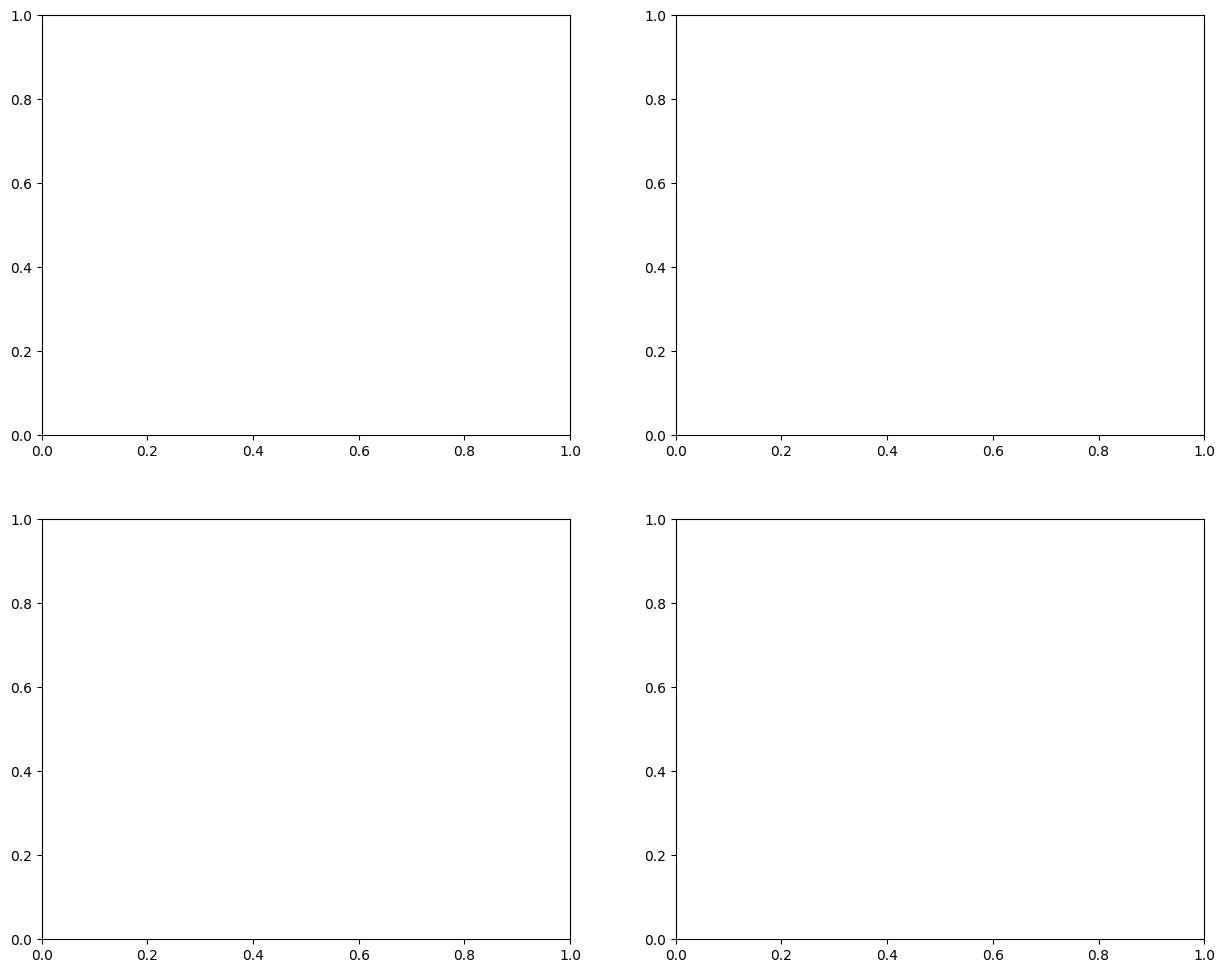

In [24]:
analyze_lopo_results(results, patient_ids)

print("\n" + "=" * 80)
print("LOPO Cross-Validation Complete!")
print("=" * 80)
